## Camera Ops Module

In [1]:
import numpy as np
import subprocess
import glob
import skimage.io as imio
import re
from skimage.color import rgb2gray
import skimage
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
IP = '10.42.0.215'

def initialFocus(sid=0, ip = IP):
    cmD='ssh nvidia@'+ip+' "echo "nvidia" | sudo -S ~/Documents/cam_on_Tegra/testCamera -id '+str(sid)+' -init "'
    pop=subprocess.run(cmD, stdout=subprocess.PIPE, shell=True)
    return pop.stdout
def moveFocus(sid=0, pos=512, ip = IP):
    cmD='ssh nvidia@'+ip+' "echo "nvidia" | sudo -S ~/Documents/cam_on_Tegra/testCamera -id '+str(sid)+' -mod '+str(pos)+'"'
    pop=subprocess.run(cmD, stdout=subprocess.PIPE, shell=True)
    return pop.stdout
def setFocus(sid=0, pos=512, ip = IP):
    cmD='ssh nvidia@'+ip+' "echo "nvidia" | sudo -S ~/Documents/cam_on_Tegra/testCamera -id '+str(sid)+' -set '+str(pos)+'"'
    pop=subprocess.run(cmD, stdout=subprocess.PIPE, shell=True)
    return pop.stdout

def grab_image(sid=0, imres=8, ip = IP):

    subprocess.run('ssh nvidia@'+ip+' "rm testGrab*"', \
                   stdout=subprocess.PIPE, shell=True)
    subprocess.run('rm testGrab*', \
                    stdout=subprocess.PIPE, shell=True)

    subprocess.run('ssh nvidia@'+ip+' "nvgstcapture-1.0 -m 1 --sensor-id '+str(sid)+' -A --capture-auto 1 \
                    --file-name testGrab --image-res '+str(imres)+'"', stdout=subprocess.PIPE, shell=True)
    subprocess.run('scp nvidia@'+ip+':testGrab* .', \
                   stdout=subprocess.PIPE, shell=True)
    pop=subprocess.run('ls',stdout=subprocess.PIPE, shell=True)
    rePop=pop.stdout
    rePop=rePop.decode("utf-8")
    fileName = re.search(r'testGrab(.*).jpg', rePop)
    fileName=fileName.group()
    pop=imio.imread(fileName)
    pop=skimage.transform.rotate(pop,180)
    
    return pop

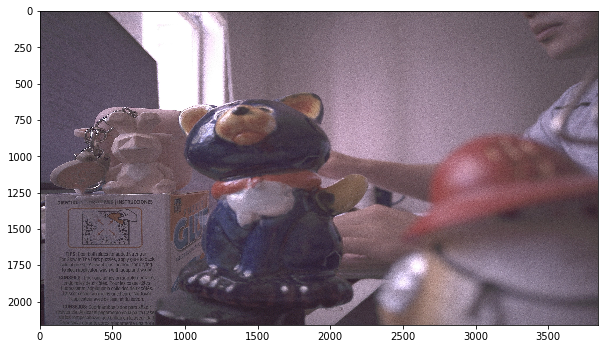

In [3]:
# initialFocus()
curr = 400
setFocus(pos = curr)

img = grab_image()
gray_img = rgb2gray(img)

plt.figure(figsize=(10, 8))
plt.imshow(img)
plt.show()

## Autofocus Module

In [4]:
from quad_solver import solver
import torch.nn as nn
import torch.nn.functional as F
import pickle
import cv2
import torch

class pixel_estimator_with_weights(nn.Module):
    def __init__(self, Weights,device = "cuda:0"):
        ## Default: gpu mode
        super(pixel_estimator_with_weights, self).__init__()
        self.device = torch.device(device)
        self.w1 = torch.from_numpy(Weights[0].transpose(3,2,0,1)).to(self.device)
        self.b1 = torch.from_numpy(Weights[1]).to(self.device)
        self.w2 = torch.tensor(Weights[2].transpose(3,2,0,1)).to(self.device)
        self.b2 = torch.tensor(Weights[3]).to(self.device)
        self.w3 = torch.tensor(Weights[4].transpose(3,2,0,1)).to(self.device)
        self.b3 = torch.tensor(Weights[5]).to(self.device)
        self.w4 = torch.tensor(Weights[6]).reshape(4,4,8,1024).permute(3,2,0,1).to(self.device)
        self.b4 = torch.tensor(Weights[7]).to(self.device)
        self.w5 = torch.tensor(Weights[8]).reshape(1,1,1024,512).permute(3,2,0,1).to(self.device)
        self.b5 = torch.tensor(Weights[9]).to(self.device)
        self.w6 = torch.tensor(Weights[10]).reshape(1,1,512,10).permute(3,2,0,1).to(self.device)
        self.b6 = torch.tensor(Weights[11]).to(self.device)
        self.w7 = torch.tensor(Weights[12]).reshape(1,1,10,1).permute(3,2,0,1).to(self.device)
        self.b7 = torch.tensor(Weights[13]).to(self.device)

    def forward(self, x):
        x = F.relu(F.conv2d(x,self.w1,bias = self.b1,stride=1))
        x = F.relu(F.conv2d(x,self.w2,bias = self.b2,stride=1,dilation=8))
        x = F.relu(F.conv2d(x,self.w3,bias = self.b3,stride=1,dilation=32))
        x = F.leaky_relu(F.conv2d(x,self.w4,bias = self.b4,stride=1,dilation=128),0.1)
        x = F.leaky_relu(F.conv2d(x,self.w5,bias = self.b5,stride=1),0.1)
        x = F.leaky_relu(F.conv2d(x,self.w6,bias = self.b6,stride=1),0.1)
        x = F.conv2d(x,self.w7,bias = self.b7,stride=1)
        return x
    
model = torch.load('autofocus.pth')
model.eval()

pixel_estimator_with_weights()

In [5]:
def crop_patches(img, window= 1023, step = 512):
    patches = []
    H, W = img.shape
    for i in range(0, H-step, step):
        for j in range(0, W-step, step):
            patches.append(img[i:i+window, j:j+window])
    return np.stack(patches)

def dist_est(img, last_dist_map = None, last_move_steps = None):
    img = np.pad(img, ((200, 200), (128, 128)), 'reflect')
#     plt.imshow(img)
#     plt.show()
    H, W = img.shape
    
    patches = crop_patches(img)
    patches = torch.from_numpy(patches).float().unsqueeze(1).cuda()

    results = []
    with torch.no_grad():
        for i in range(patches.size(0)):
            results.append(model(patches[i:i+1]))
    results = torch.stack(results)

    results = results.cpu().numpy()
    results = results.squeeze()
    
    if last_dist_map is None:
        last_dist_map = np.ones((H-512, W-512))

    k = 0
    n_img = np.zeros((H-512, W-512))
    for i in range(0, H-512, 512):
        for j in range(0, W-512, 512):
            n_img[i:i+512, j:j+512] = results[k]
            k += 1
    n_img = np.clip(n_img, 0, 8)
    
    if last_move_steps is not None:
        ## Focus direction: simple check
        mapa = n_img - last_move_steps
        mapb = -n_img - last_move_steps
        diffa = np.abs(mapa) - last_dist_map
        diffb = np.abs(mapb) - last_dist_map
        mask = (np.abs(diffa) < np.abs(diffb)).astype(np.float64)
        n_img = (n_img * mask + (1-mask) * (-n_img))

    return n_img

In [6]:
n_img = dist_est(gray_img)

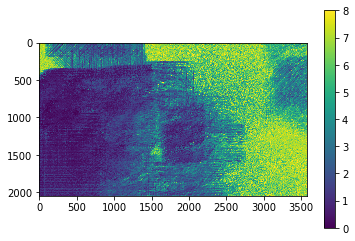

(2048, 3584)


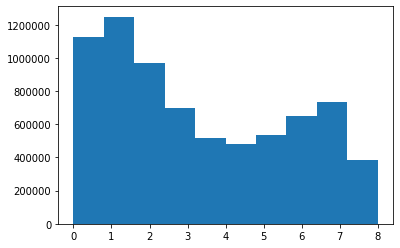

In [7]:
plt.imshow(n_img)
plt.colorbar()
plt.show()
plt.hist(n_img.flatten())
print(n_img.shape)

In [8]:
## autofocus map is given withi range(-8, 8)

In [9]:
def observation_t(I, n_img):
    
    I = I[56:-56, 128:-128]*2-1
    n_img = n_img/8
    obs = np.concatenate([I, n_img[..., np.newaxis]], axis = 2)
    obs = cv2.resize(obs, (64, 128))
    
    return np.float32(obs.transpose(2, 0, 1)[np.newaxis])

## Focus Ctrl Module

[*] Loading model from ckpt/best_model
current epoch: 164 --- best loss: 1.1481315611744178
tensor([[-0.3863]], device='cuda:0')
480.6730090933058


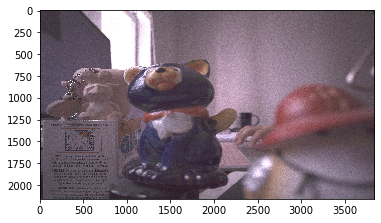

tensor([[-0.3020]], device='cuda:0')
505.3168867047644


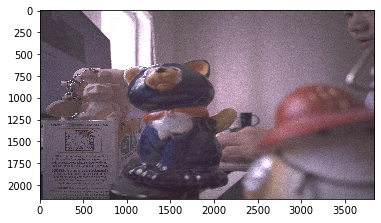

tensor([[-0.4220]], device='cuda:0')
470.46030950479553


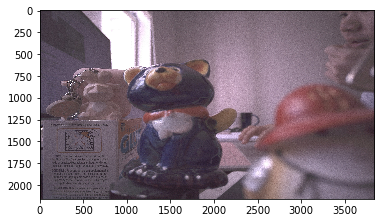

tensor([[-0.0871]], device='cuda:0')
572.5964200157655


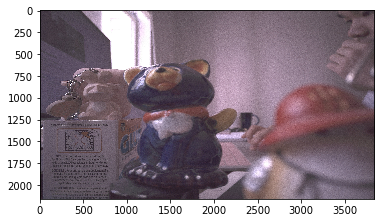

tensor([[-0.2449]], device='cuda:0')
522.5577958506199


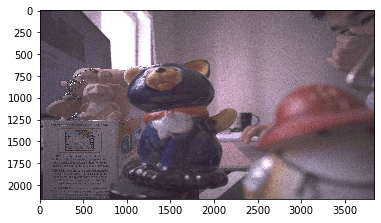

tensor([[-0.0715]], device='cuda:0')
577.7695259354748


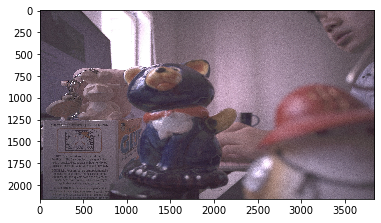

tensor([[-0.2213]], device='cuda:0')
529.8071401358433


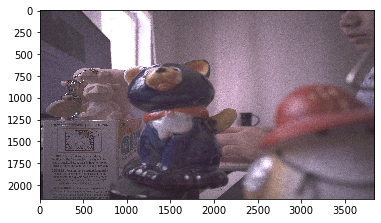

tensor([[-0.1254]], device='cuda:0')
560.0891313600757


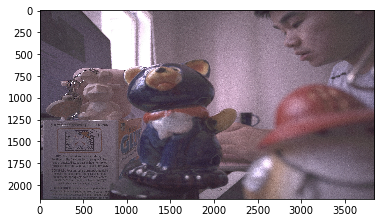

tensor([[-0.0552]], device='cuda:0')
583.2414908089875


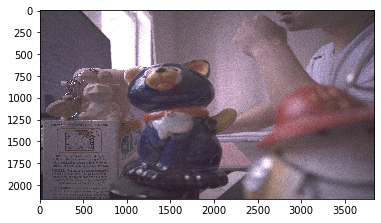

tensor([[-0.2198]], device='cuda:0')
530.2591107080816


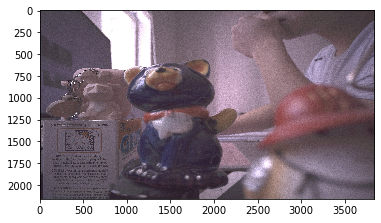

In [10]:
import os
from model import *
import warnings
warnings.simplefilter("ignore", UserWarning)
from quad_solver import *

def load_checkpoint(ckpt_path, model):
    
    ckpt_dir = 'ckpt/'+ckpt_path

    print("[*] Loading model from {}".format(ckpt_dir))

    ckpt_dir = '.'
    filename = 'rfc_model_best.pth.tar'
    ckpt_path = os.path.join(ckpt_dir, filename)
    ckpt = torch.load(ckpt_path)

    # load variables from checkpoint
    start_epoch = ckpt['epoch']
    best_loss = ckpt['best_valid_mse']
    print("current epoch: {} --- best loss: {}".format(start_epoch, best_loss))
    model.load_state_dict(ckpt['model_state'])
    #optimizer.load_state_dict(ckpt['optim_state'])   

    return model

rlmodel = focusLocNet(0.17, 4, 256, 1).to("cuda:0")
rlmodel = load_checkpoint('best_model', rlmodel)
rlmodel = rlmodel.eval()

def reset(curr):
    h = [torch.zeros(1, 1, 256).cuda(),
                  torch.zeros(1, 1, 256).cuda()]
    l = torch.tensor(loc_mapping(curr)).reshape(1, 1).cuda()
    return h, l

with torch.no_grad():
    h, l = reset(curr)
    
    for i in range(10):
        input_t = torch.from_numpy(observation_t(img, -n_img)).cuda()
        temp = l.item()
        l = l * 2
        h, mu, l, _, _ = rlmodel(input_t, l, h)
        l = l/2
        mu = mu/2
        print(l)
        curr = curr + solver(curr, 8*(l.item() - temp))
        print(curr)
        
        curr = np.clip(curr, 400, 1000)
        
        setFocus(pos = curr)
        img = grab_image()
        gray_img = rgb2gray(img)
        n_img = dist_est(gray_img, np.abs(n_img), 8*(l.item() - temp))
        
        plt.imshow(img)
        plt.show()
    
